In [1]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
import os
import torch.optim as optim
import optuna

/opt/anaconda3/envs/flwr-niid-bench/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class AccuracyPredictor(nn.Module):
    def __init__(self):
        super(AccuracyPredictor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(4, 32),   # 4 inputs → camada oculta com 32 neurônios
            nn.ReLU(),
            nn.Linear(32, 16),  # camada oculta → 16 neurônios
            nn.ReLU(),
            nn.Linear(16, 1)    # saída: acurácia prevista (1 valor)
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
# Load CSV log
df = pd.read_csv("results/fedavg_training_log2.csv")

# Lista de dataframes válidos
dfs = []

# Verifica se ao menos um foi carregado
if not dfs:
    raise ValueError("Nenhum dos arquivos foi encontrado. Verifique os caminhos.")

# Concatena os dataframes
df = pd.concat(dfs, ignore_index=True)

# Drop any rows with missing values (e.g. round 0)
df = df.dropna().reset_index(drop=True)

# Select input features and target
features = ['round', 'fraction_fit', 'fraction_fit_prev', 'accuracy_prev']
target = ['accuracy']

# Convert to NumPy arrays
X_raw = df[features].values.astype(np.float32)
y_raw = df[target].values.astype(np.float32)

# Normalize only the 'round' column (assumed to be in range [1, 50])
X_raw[:, 0] = (X_raw[:, 0] - 1) / 39.0  # Normalize round to [0,1]

# Keep other columns as they are
X = X_raw
y = y_raw  # Assuming accuracy is already in [0,1]

In [4]:
class FedAccuracyDataset(Dataset):
    """Custom dataset to hold normalized federated learning data."""
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [5]:
# Split into training and validation sets (80/20 split)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Create datasets
train_dataset = FedAccuracyDataset(X_train, y_train)
val_dataset = FedAccuracyDataset(X_val, y_val)

# Create PyTorch DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)

In [6]:
# Instantiate model, loss, optimizer
model = AccuracyPredictor()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
epochs = 100
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss/len(train_loader):.4f} | Val Loss: {val_loss/len(val_loader):.4f}")

# After training loop ends
torch.save(model.state_dict(), "accuracy_predictor.pt")
print("Model saved to 'accuracy_predictor.pt'")


Epoch 1/100 | Train Loss: 0.0441 | Val Loss: 0.0162
Epoch 2/100 | Train Loss: 0.0167 | Val Loss: 0.0091
Epoch 3/100 | Train Loss: 0.0082 | Val Loss: 0.0037
Epoch 4/100 | Train Loss: 0.0053 | Val Loss: 0.0032
Epoch 5/100 | Train Loss: 0.0048 | Val Loss: 0.0035
Epoch 6/100 | Train Loss: 0.0037 | Val Loss: 0.0022
Epoch 7/100 | Train Loss: 0.0029 | Val Loss: 0.0023
Epoch 8/100 | Train Loss: 0.0021 | Val Loss: 0.0015
Epoch 9/100 | Train Loss: 0.0016 | Val Loss: 0.0010
Epoch 10/100 | Train Loss: 0.0012 | Val Loss: 0.0007
Epoch 11/100 | Train Loss: 0.0009 | Val Loss: 0.0006
Epoch 12/100 | Train Loss: 0.0007 | Val Loss: 0.0005
Epoch 13/100 | Train Loss: 0.0006 | Val Loss: 0.0002
Epoch 14/100 | Train Loss: 0.0005 | Val Loss: 0.0008
Epoch 15/100 | Train Loss: 0.0005 | Val Loss: 0.0001
Epoch 16/100 | Train Loss: 0.0004 | Val Loss: 0.0002
Epoch 17/100 | Train Loss: 0.0002 | Val Loss: 0.0002
Epoch 18/100 | Train Loss: 0.0001 | Val Loss: 0.0001
Epoch 19/100 | Train Loss: 0.0001 | Val Loss: 0.0001
Ep

In [7]:
# Example input: [round, fraction_fit, fraction_fit_prev, accuracy_prev]
input_data = np.array([[35, 0.8, 0.75, 0.5064]])  # shape: (1, 4)

# Manually normalize only the round (column 0)
input_data[:, 0] = (input_data[:, 0] - 1) / 39.0  # Normalize round to [0, 1]

# Convert to tensor
input_tensor = torch.tensor(input_data, dtype=torch.float32)

In [8]:
import numpy as np
import torch

# Example input: [round, fraction_fit, fraction_fit_prev, accuracy_prev]
input_data = np.array([[35, 0.8, 0.75, 0.5064]], dtype=np.float32)  # shape: (1, 4)

# ✅ Normalize round based on 40 rounds
input_data[:, 0] = (input_data[:, 0] - 1) / 39.0

# Convert to tensor
input_tensor = torch.tensor(input_data, dtype=torch.float32)

# Ensure model is in evaluation mode
model.eval()

# 🔮 Predict
with torch.no_grad():
    predicted_accuracy = model(input_tensor).numpy()

# Print predicted accuracy (already in [0, 1] range)
print(f"📈 Predicted Accuracy for round 35: {predicted_accuracy[0][0]:.4f}")


📈 Predicted Accuracy for round 35: 0.4999


In [9]:
def simulate_accuracy(round, fraction_fit, fraction_fit_prev, accuracy_prev):
    """Use trained model to predict current accuracy"""
    
    # Prepare input and normalize only 'round'
    X = np.array([[round, fraction_fit, fraction_fit_prev, accuracy_prev]], dtype=np.float32)
    X[:, 0] = (X[:, 0] - 1) / 39.0  # Normalize round for 40 rounds

    # Convert to tensor
    X_tensor = torch.tensor(X, dtype=torch.float32)

    # Predict using trained model
    model.eval()
    with torch.no_grad():
        y_pred = model(X_tensor).numpy()

    # Output is already in [0, 1] range
    return y_pred[0][0]

def objective(trial):
    round_now = 31
    accuracy_prev = 0.51
    fraction_fit_prev = 0.3

    fraction_fit = trial.suggest_float("fraction_fit", 0.1, 1.0)

    predicted_accuracy = simulate_accuracy(round_now, fraction_fit, fraction_fit_prev, accuracy_prev)

    # ✅ Penalize solutions with worse accuracy
    if predicted_accuracy < accuracy_prev:
        return float("inf"), fraction_fit  # Discard this solution

    return -predicted_accuracy, fraction_fit

In [10]:
study = optuna.create_study(directions=["minimize", "minimize"])
study.optimize(objective, n_trials=100)

# Show Pareto front
for t in study.best_trials:
    acc = -t.values[0]
    frac = t.values[1]
    print(f"✅ Accuracy: {acc:.4f} | 📉 Fraction Fit: {frac:.2f}")

[I 2025-07-18 15:47:59,566] A new study created in memory with name: no-name-ebe6da6d-4769-461a-8973-339ce1258523
[I 2025-07-18 15:47:59,567] Trial 0 finished with values: [inf, 0.510886903037475] and parameters: {'fraction_fit': 0.510886903037475}.
[I 2025-07-18 15:47:59,568] Trial 1 finished with values: [inf, 0.3309528073131241] and parameters: {'fraction_fit': 0.3309528073131241}.
[I 2025-07-18 15:47:59,568] Trial 2 finished with values: [inf, 0.47994659175531873] and parameters: {'fraction_fit': 0.47994659175531873}.
[I 2025-07-18 15:47:59,569] Trial 3 finished with values: [inf, 0.3859909581873434] and parameters: {'fraction_fit': 0.3859909581873434}.
[I 2025-07-18 15:47:59,569] Trial 4 finished with values: [inf, 0.2279082636441887] and parameters: {'fraction_fit': 0.2279082636441887}.
[I 2025-07-18 15:47:59,569] Trial 5 finished with values: [inf, 0.4131366699947261] and parameters: {'fraction_fit': 0.4131366699947261}.
[I 2025-07-18 15:47:59,570] Trial 6 finished with values: 

✅ Accuracy: -inf | 📉 Fraction Fit: 0.11


In [11]:
# Define trade-off weights: alpha = weight for accuracy, beta = weight for communication
alpha = 0.4   # Weight for maximizing accuracy
beta = 0.6   # Weight for minimizing fraction_fit

best_score = float("inf")
best_trial = None

for t in study.best_trials:
    acc = -t.values[0]               # Remember: accuracy was negated in optimization
    frac = t.values[1]
    
    # Custom objective: higher accuracy is better, lower fraction is better
    score = -alpha * acc + beta * frac

    if score < best_score:
        best_score = score
        best_trial = t

# ✅ Show the selected best trade-off
best_acc = -best_trial.values[0]
best_frac = best_trial.values[1]
print(f"🎯 Best Trade-off → Accuracy: {best_acc:.4f} | Fraction Fit: {best_frac:.2f}")

AttributeError: 'NoneType' object has no attribute 'values'

📉 MSE on original dataset: 0.000129
📈 R² Score on original dataset: 0.9909


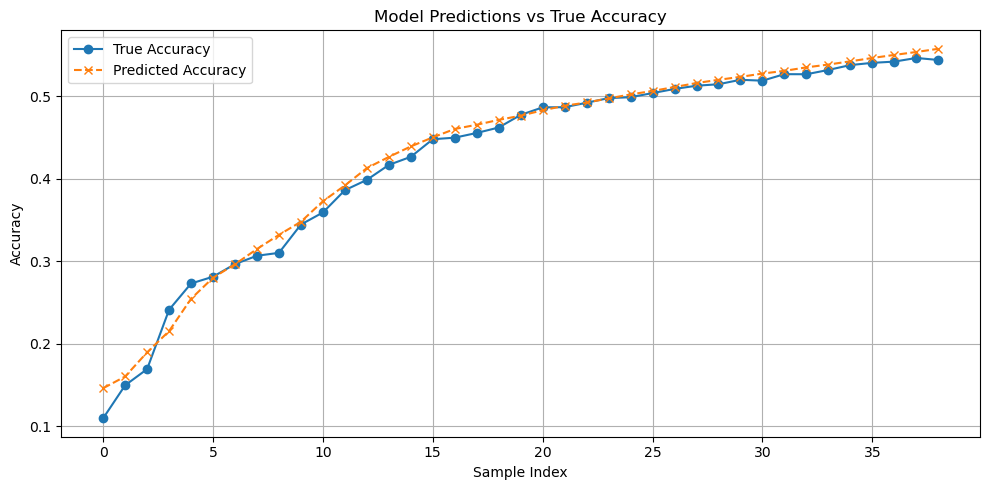

In [ ]:
import pandas as pd
import numpy as np
import torch
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 🔹 Load the dataset
df = pd.read_csv("/Users/freitas/Documents/git-projects/niid_bench/results/fedavg_training_log2.csv")

# 🔹 Drop missing values (e.g., round 0)
df = df.dropna().reset_index(drop=True)

# 🔹 Prepare inputs and target
features = ['round', 'fraction_fit', 'fraction_fit_prev', 'accuracy_prev']
target = ['accuracy']

X = df[features].values.astype(np.float32)
y_true = df[target].values.astype(np.float32)

# 🔹 Normalize only 'round' (for 40 rounds: [1, 40] → [0, 1])
X_scaled = X.copy()
X_scaled[:, 0] = (X_scaled[:, 0] - 1) / 39.0

# 🔹 Convert to PyTorch tensor
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)

# 🔹 Run predictions using trained model
model.eval()
with torch.no_grad():
    y_pred_tensor = model(X_tensor)
    y_pred = y_pred_tensor.numpy()

# 🔹 Evaluate
mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"📉 MSE on original dataset: {mse:.6f}")
print(f"📈 R² Score on original dataset: {r2:.4f}")

# 🔹 (Optional) Visualization
plt.figure(figsize=(10, 5))
plt.plot(y_true, label="True Accuracy", marker='o')
plt.plot(y_pred, label="Predicted Accuracy", linestyle="--", marker='x')
plt.title("Model Predictions vs True Accuracy")
plt.xlabel("Sample Index")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Model with trend as feature

In [13]:
from niid_bench.control_utils import AccuracyPredictor

from experiment_result import ExperimentResult, load_experiments_from_csv
import matplotlib.pyplot as plt
import numpy as np
import niid_bench.utils_postprocess as utils_pp

In [14]:
csv_file_path = "experiments_fl.csv"
experiments = load_experiments_from_csv(csv_file_path)

print(len(experiments))

# Define filter criteria
filter_criteria = {
    "ID": [154,155,156,157]
}

# Apply the single filter and plot the results

filtered_experiments = utils_pp.filter_experiments(experiments, filter_criteria)

print(len(filtered_experiments))
#plot_centralized_metrics(filtered_experiments, title="Accuracy Over Rounds - MNIST FedAvg Label Quantity")
#utils_pp.plot_centralized_metrics(filtered_experiments, title="Experiment Results", metric = 'centralized_accuracy')
#utils_pp.plot_distributed_metrics(filtered_experiments, title="Experiment Results", metric = 'distributed_test_loss')


[Errno 2] No such file or directory: 'nan/centralized_metrics.csv'
[Errno 2] No such file or directory: 'nan/centralized_metrics.csv'
150
4


In [15]:
# Supondo que você já tenha `filtered_experiments` da forma correta
all_metrics = []

for exp in filtered_experiments:
    df = exp.centralized_metrics.copy()
    all_metrics.append(df)

# Concatena todos os DataFrames
merged_metrics = pd.concat(all_metrics, ignore_index=True)

# Exibe preview
print(merged_metrics.head())

   accuracy  round  fraction_fit  fraction_fit_prev  \
0    0.1014      1           0.5                NaN   
1    0.1524      2           0.5                0.5   
2    0.2370      3           0.5                0.5   
3    0.2420      4           0.5                0.5   
4    0.2718      5           0.5                0.5   

   centralized_accuracy_prev  centralized_accuracy  accuracy_trend  
0                        NaN                0.1014             NaN  
1                     0.1014                0.1524             NaN  
2                     0.1524                0.2370             NaN  
3                     0.2370                0.2420             NaN  
4                     0.2420                0.2718         0.04304  


In [28]:
df_clean = merged_metrics.dropna(subset=["centralized_accuracy_prev", "accuracy_trend"]).reset_index(drop=True)
print(df_clean[["round", "centralized_accuracy_prev", "accuracy_trend", "accuracy", "fraction_fit", "fraction_fit_prev", "centralized_accuracy"]].head())

print(len(df_clean))

   round  centralized_accuracy_prev  accuracy_trend  accuracy  fraction_fit  \
0      5                     0.2420         0.04304    0.2718           0.5   
1      6                     0.2718         0.03144    0.2922           0.5   
2      7                     0.2922         0.02044    0.3141           0.5   
3      8                     0.3141         0.02317    0.3367           0.5   
4      9                     0.3367         0.02085    0.3538           0.5   

   fraction_fit_prev  centralized_accuracy  
0                0.5                0.2718  
1                0.5                0.2922  
2                0.5                0.3141  
3                0.5                0.3367  
4                0.5                0.3538  
224


In [23]:

# Filter the dataset to ensure only valid rows
df_clean = df.dropna(subset=["centralized_accuracy_prev", "accuracy_trend"]).reset_index(drop=True)

# ✅ Select input features and target
features = ['round', 'fraction_fit', 'fraction_fit_prev', 'centralized_accuracy_prev', 'accuracy_trend']
target = ['centralized_accuracy']  # Assuming this is your target now

# Convert to NumPy arrays
X_raw = df_clean[features].values.astype(np.float32)
y_raw = df_clean[target].values.astype(np.float32)

# ✅ Normalize only the 'round' column to [0, 1]
X_raw[:, 0] = (X_raw[:, 0] - 1) / 59.0  # if max round is 60

# Final assignment
X = X_raw
y = y_raw

In [24]:
class FedAccuracyDataset(Dataset):
    """Custom dataset to hold normalized federated learning data."""
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [25]:
# Split into training and validation sets (80/20 split)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Create datasets
train_dataset = FedAccuracyDataset(X_train, y_train)
val_dataset = FedAccuracyDataset(X_val, y_val)

# Create PyTorch DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)

In [29]:
# Instantiate model, loss, optimizer
model = AccuracyPredictor()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
epochs = 100
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss/len(train_loader):.4f} | Val Loss: {val_loss/len(val_loader):.4f}")

# After training loop ends
torch.save(model.state_dict(), "accuracy_predictor_with_trends.pt")
print("Model saved to 'accuracy_predictor_with_trends.pt'")

Epoch 1/100 | Train Loss: 0.0219 | Val Loss: 0.0343
Epoch 2/100 | Train Loss: 0.0098 | Val Loss: 0.0045
Epoch 3/100 | Train Loss: 0.0036 | Val Loss: 0.0024
Epoch 4/100 | Train Loss: 0.0011 | Val Loss: 0.0023
Epoch 5/100 | Train Loss: 0.0007 | Val Loss: 0.0013
Epoch 6/100 | Train Loss: 0.0006 | Val Loss: 0.0014
Epoch 7/100 | Train Loss: 0.0004 | Val Loss: 0.0008
Epoch 8/100 | Train Loss: 0.0003 | Val Loss: 0.0006
Epoch 9/100 | Train Loss: 0.0002 | Val Loss: 0.0008
Epoch 10/100 | Train Loss: 0.0002 | Val Loss: 0.0006
Epoch 11/100 | Train Loss: 0.0002 | Val Loss: 0.0006
Epoch 12/100 | Train Loss: 0.0002 | Val Loss: 0.0005
Epoch 13/100 | Train Loss: 0.0002 | Val Loss: 0.0005
Epoch 14/100 | Train Loss: 0.0002 | Val Loss: 0.0005
Epoch 15/100 | Train Loss: 0.0002 | Val Loss: 0.0005
Epoch 16/100 | Train Loss: 0.0001 | Val Loss: 0.0005
Epoch 17/100 | Train Loss: 0.0001 | Val Loss: 0.0004
Epoch 18/100 | Train Loss: 0.0002 | Val Loss: 0.0005
Epoch 19/100 | Train Loss: 0.0001 | Val Loss: 0.0004
Ep